# Machine Learning Final Project Clustering Tool
By Shaun Guyette, Austin Monroe, and Jarod Teague

In [1]:
import nltk
import pandas as pd
from sklearn import preprocessing

# from google.colab import files
# uploaded = files.upload() # uncomment if need to upload file
tweet_data = pd.read_csv("Tweets.csv")
delta_tweets = tweet_data[tweet_data['airline'] == 'Delta']
delta_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
6746,570309345281486848,positive,0.6469,NaN,NaN,Delta,NaN,jaxbra,NaN,0,@JetBlue Yesterday on my way from EWR to FLL j...,NaN,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
6747,570309308937842688,neutral,0.6869,NaN,NaN,Delta,NaN,Oneladyyouadore,NaN,0,@JetBlue I hope so because I fly very often an...,NaN,2015-02-24 11:48:29 -0800,Georgia,Quito
6748,570308513181904901,neutral,1.0000,NaN,NaN,Delta,NaN,Oneladyyouadore,NaN,0,"@JetBlue flight 1041 to Savannah, GA",NaN,2015-02-24 11:45:20 -0800,Georgia,Quito
6749,570307820962373632,negative,1.0000,Flight Attendant Complaints,0.6522,Delta,NaN,Oneladyyouadore,NaN,0,"@JetBlue They weren't on any flight, they just...",NaN,2015-02-24 11:42:34 -0800,Georgia,Quito
6750,570305363859406848,negative,1.0000,Bad Flight,1.0000,Delta,NaN,Oneladyyouadore,NaN,0,@JetBlue everyone is here but our pilots are n...,NaN,2015-02-24 11:32:49 -0800,Georgia,Quito


In [2]:
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

tweets_x = delta_tweets['text']

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    temp = [ps.stem(w) for w in temp]
    temp = " ".join(word for word in temp)
    return temp

tweets_x = [clean_tweet(tw) for tw in tweets_x]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jarod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-2-1547b48b3a37>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


In [3]:
# import and use CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(tweets_x)

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(tweets_x)

In [4]:
from sklearn.cluster import KMeans
wcss = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train_counts)
    wcss.append(kmeans.inertia_)

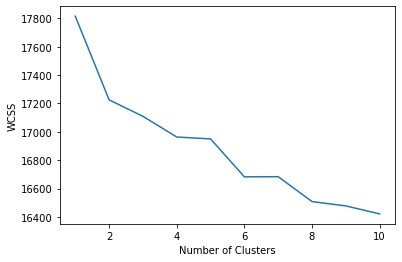

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
k = 5
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
kmeans.fit(X_train_counts)


cluster_map = pd.DataFrame()
cluster_map['tweets'] = delta_tweets['text']
cluster_map['sentiment'] = delta_tweets['airline_sentiment']
cluster_map['cluster'] = kmeans.labels_

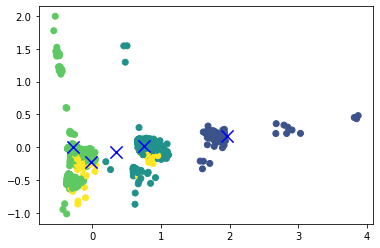

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state = 42)
reduced_features = pca.fit_transform(X_train_counts.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(X_train_counts))
plt.scatter(reduced_cluster_centers[:,0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()

In [8]:
for i in range(0,k):
    d = kmeans.transform(X_train_counts)[:, i]
    ind = np.argsort(d)[::][:10]
    # print(ind)
    print("Cluster " + str(i + 1) + ": ")
    for j in range(0, 10):
        print(delta_tweets.iloc[ind[j], 1] + ", " + delta_tweets.iloc[ind[j], 10])
    print("\n")

Cluster 1: 
negative, @JetBlue flying out of BUF 2 BOS, missing captain... Really? Delayed til 2:00... Not happy...
negative, @JetBlue get me home! Flight 2016 from buf to Bos is missing a captain!? Really!?
neutral, @JetBlue ...really?
neutral, @JetBlue really caring??
neutral, @JetBlue @BucketObolts Same
neutral, @JetBlue or she ;)
negative, @JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy
neutral, @JetBlue  will do.
positive, Then you better #HoldOn - #EverythingsGonnaBeAlright @jetblue 4 our #brandloveaffair https://t.co/64kN6GEEP8 #TrueBlueLove #travel #business
neutral, @JetBlue flight16?


Cluster 2: 
negative, @JetBlue why is the buffalo flight so Late Flight?
negative, @JetBlue Cancelled Flighted 😢
positive, @JetBlue great flight http://t.co/E0R0NTO4TR
neutral, @JetBlue flight 2008
neutral, @JetBlue How do I know if my flight was deemed a dark flight?
negative, @JetBlue delayed flight bummer
negative, @JetBlue why are we delayed :( flight 1601
negative, @JetBlue why did

In [9]:
wcss = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_)

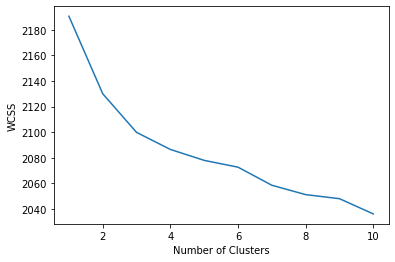

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
k = 3
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
kmeans.fit(X_train_tfidf)


cluster_map = pd.DataFrame()
cluster_map['tweets'] = delta_tweets['text']
cluster_map['sentiment'] = delta_tweets['airline_sentiment']
cluster_map['cluster'] = kmeans.labels_

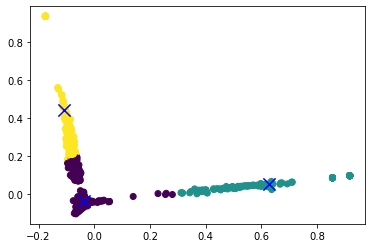

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state = 42)
reduced_features = pca.fit_transform(X_train_tfidf.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(X_train_tfidf))
plt.scatter(reduced_cluster_centers[:,0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()

In [13]:
for i in range(0,k):
    d = kmeans.transform(X_train_tfidf)[:, i]
    ind = np.argsort(d)[::][:10]
    # print(ind)
    print("Cluster " + str(i + 1) + ": ")
    for j in range(0, 10):
        print(delta_tweets.iloc[ind[j], 1] + ", " + delta_tweets.iloc[ind[j], 10])
    print("\n")

Cluster 1: 
neutral, @JetBlue or she ;)
neutral, @JetBlue @BucketObolts Same
neutral, @JetBlue  will do.
negative, @JetBlue well, now saying our flight is going to be Cancelled Flighted &amp; that by not changing earlier, we missed our chance to get out tomorrow. 1/2
negative, @JetBlue flight for tomorrow morning Cancelled Flighted &amp; can't seem to rebook me. They can't even get me a seat. No clear answer on why Cancelled Flighted.
negative, @JetBlue - trying to fly from BOS to JFK. Flight delayed. Traveling with kids. Book a hotel or are we getting out tonight?
negative, @JetBlue Cancelled Flighted my flight. Went with another airline 2 leave 2day. They Cancelled Flighted also. Called JetBlue &amp; got same flight but now $250 more👺
neutral, @JetBlue A month ago I had a flight booked but then had to Cancelled Flight it... I'm now Flight Booking Problems a separate flight for a different occasion.
negative, @JetBlue I can't do that flight. I need a Late Flightr one! I need you to ch